In [1]:
# Import common libraries
import pandas as pd
from itertools import compress
from collections import defaultdict
from copy import deepcopy
from pprint import pprint
import os

# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level

# Import MNE-NIRS processing
import mne
from mne_nirs.channels import get_long_channels
from mne_nirs.channels import picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne.preprocessing.nirs import beer_lambert_law, optical_density,\
    temporal_derivative_distribution_repair, scalp_coupling_index
from mne_nirs.signal_enhancement import enhance_negative_correlation

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns

# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects

ignore = [".DS_Store", "sub-03"]

# Based on Guides Published Here
# https://mne.tools/mne-nirs/stable/auto_examples/general/plot_16_waveform_group.html

In [2]:
def individual_analysis(bids_path):

    # Read data with annotations in BIDS format
    # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity = mne.io.read_raw_snirf(bids_path, verbose=True, preload=False)
    raw_intensity = get_long_channels(raw_intensity, min_dist=0.01)
    
    channel_types = raw_intensity.copy()
    print(channel_types)
    
    raw_intensity.annotations.rename({'4': 'Control', '2': 'Neutral', '3': 'Inflammatory', '1':'Practice'})

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    sci = scalp_coupling_index(raw_od, h_freq=1.35, h_trans_bandwidth=0.1)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))
    # raw_od.interpolate_bads()

    # Downsample and apply signal cleaning techniques
    raw_od.resample(0.8)
    raw_od = temporal_derivative_distribution_repair(raw_od)

    # Convert to haemoglobin and filter
    raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
    raw_haemo = raw_haemo.filter(0.02, 0.3,
                                 h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                 verbose=False)

    # Apply further data cleaning techniques and extract epochs
    raw_haemo = enhance_negative_correlation(raw_haemo)
    # Extract events but ignore those with
    # the word Ends (i.e. drop ExperimentEnds events)
    events, event_dict = events_from_annotations(raw_haemo, verbose=False)
    
    # Remove all STOP triggers to hardcode duration to 30 secs per MNE specs
    events = events[::2]
    print(events)

    epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-1, tmax=15,
                    reject=dict(hbo=200e-6), reject_by_annotation=True,
                    proj=True, baseline=(None, 0), detrend=0,
                    preload=True, verbose=False)

    return raw_haemo, epochs

In [3]:
all_evokeds = defaultdict(list)

subjects = os.listdir("../BIDS_Anon/")
for sub in subjects:
    if sub not in ignore:
        # Create path to file based on experiment info
        f_path = f'../BIDS_Anon/{sub}/nirs/{sub}_task-AnonCom_nirs.snirf'

        # Analyse data and return both ROI and channel results
        raw_haemo, epochs = individual_analysis(f_path)
        
        # Save individual-evoked participant data along with others in all_evokeds
        for cidx, condition in enumerate(epochs.event_id):
            all_evokeds[condition].append(epochs[condition].average())
            
# pprint(all_evokeds)

Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Anon/sub-06/nirs/sub-06_task-AnonCom_nirs.snirf
<RawSNIRF | sub-06_task-AnonCom_nirs.snirf, 36 x 18358 (1804.5 s), ~5.2 MB, data loaded>
[[ 223    0    1]
 [ 311    0    1]
 [ 386    0    1]
 [ 499    0    4]
 [ 587    0    4]
 [ 675    0    4]
 [ 820    0    3]
 [ 908    0    3]
 [ 991    0    3]
 [1149    0    2]
 [1237    0    2]
 [1325    0    2]]
Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADataAnalysisScripts/../BIDS_Anon/sub-07/nirs/sub-07_task-AnonCom_nirs.snirf
<RawSNIRF | sub-07_task-AnonCom_nirs.snirf, 36 x 17825 (1752.1 s), ~5.1 MB, data loaded>
[[ 254    0    1]
 [ 333    0    1]
 [ 382    0    1]
 [ 468    0    4]
 [ 542    0    4]
 [ 627    0    4]
 [ 792    0    3]
 [ 877    0    3]
 [ 958    0    3]
 [1112    0    2]
 [1196    0    2]
 [1284    0    2]]
Loading /Users/nolanbrady/Desktop/LabResearch/IndependentStudy/DataAnalysis/FADa

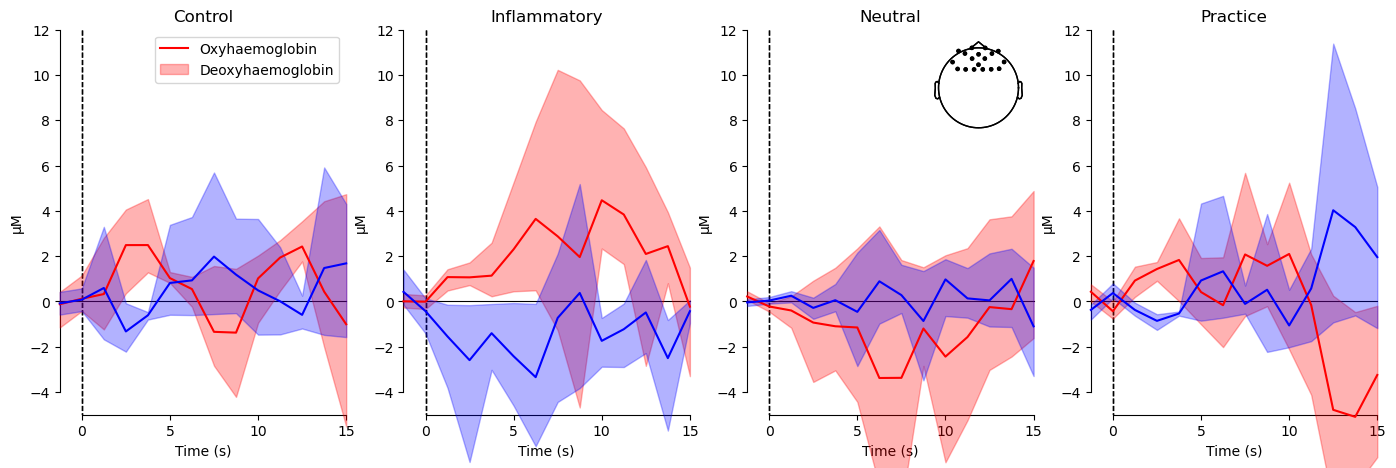

In [4]:
# Print figures

# Specify the figure size and limits per chromophore
fig, axes = plt.subplots(nrows=1, ncols=len(all_evokeds), figsize=(17, 5))
lims = dict(hbo=[-5, 12], hbr=[-5, 12])

for (pick, color) in zip(['hbo', 'hbr'], ['r', 'b']):
    for idx, evoked in enumerate(all_evokeds):
        plot_compare_evokeds({evoked: all_evokeds[evoked]}, combine='mean',
                             picks=pick, axes=axes[idx], show=False,
                             colors=[color], legend=False, ylim=lims, ci=0.95,
                             show_sensors=idx == 2)
        axes[idx].set_title('{}'.format(evoked))
axes[0].legend(["Oxyhaemoglobin", "Deoxyhaemoglobin"])

In [5]:
# Extract Evoked Amplitude

df = pd.DataFrame(columns=['ID', 'Chroma', 'Condition', 'Value'])

for idx, evoked in enumerate(all_evokeds):
    subj_id = 0
    for subj_data in all_evokeds[evoked]:
        subj_id += 1
        for chroma in ["hbo", "hbr"]:
            data = deepcopy(subj_data)
            value = data.crop(tmin=-1, tmax=15).data.mean() * 1.0e6

            # Append metadata and extracted feature to dataframe
            this_df = pd.DataFrame(
                {'ID': subj_id, 'Chroma': chroma,
                 'Condition': evoked, 'Value': value}, index=[0])
            df = pd.concat([df, this_df], ignore_index=True)
df.reset_index(inplace=True, drop=True)
df['Value'] = pd.to_numeric(df['Value'])  # some Pandas have this as object

# You can export the dataframe for analysis in your favorite stats program
df.to_csv("stats-export.csv")

# Print out the first entries in the dataframe
df

,ID,Chroma,Condition,Value
0,1,hbo,Control,0.556901
1,1,hbr,Control,0.556901
2,2,hbo,Control,-0.062691
3,2,hbr,Control,-0.062691
4,3,hbo,Control,1.181590
5,3,hbr,Control,1.181590
6,1,hbo,Inflammatory,0.371678
7,1,hbr,Inflammatory,0.371678
8,2,hbo,Inflammatory,1.452303
9,2,hbr,Inflammatory,1.452303


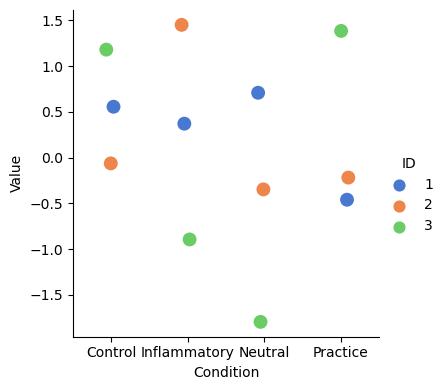

In [6]:
# Plot the Data
sns.catplot(x="Condition", y="Value", hue="ID", data=df.query("Chroma == 'hbo'"), ci=None, palette="muted", height=4, s=10)


In [7]:
# Inflammatory vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Neutral', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM    Dependent Variable:    Value  
No. Observations:     6          Method:                REML   
No. Groups:           3          Scale:                 0.5758 
Min. group size:      2          Log-Likelihood:        -7.0918
Max. group size:      2          Converged:             Yes    
Mean group size:      2.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.310    0.703  0.441 0.659 -1.067  1.687
Condition[T.Neutral] -0.788    0.620 -1.271 0.204 -2.002  0.427
Group Var             0.905    2.223                           
===============================================================

"""

In [8]:
# Control vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Control', 'Neutral']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:                MixedLM    Dependent Variable:    Value  
No. Observations:     6          Method:                REML   
No. Groups:           3          Scale:                 0.9845 
Min. group size:      2          Log-Likelihood:        -6.7431
Max. group size:      2          Converged:             Yes    
Mean group size:      2.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.559    0.573  0.975 0.329 -0.564  1.681
Condition[T.Neutral] -1.036    0.810 -1.279 0.201 -2.624  0.552
Group Var             0.000                                    
===============================================================

"""

In [9]:
# Control vs Inflam

input_data = df.query("Condition in ['Control', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimizatio

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                 MixedLM      Dependent Variable:      Value  
No. Observations:      6            Method:                  REML   
No. Groups:            3            Scale:                   0.8830 
Min. group size:       2            Log-Likelihood:          -6.5292
Max. group size:       2            Converged:               No     
Mean group size:       2.0                                          
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.559    0.543  1.029 0.304 -0.506  1.623
Condition[T.Inflammatory] -0.249    0.767 -0.324 0.746 -1.752  1.255
Group Var                  0.002                                    
====================================================================

"""

In [10]:
# Practice vs Inflam

input_data = df.query("Condition in ['Practice', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimizatio

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                 MixedLM    Dependent Variable:    Value  
No. Observations:      6          Method:                REML   
No. Groups:            3          Scale:                 1.1926 
Min. group size:       2          Log-Likelihood:        -7.1295
Max. group size:       2          Converged:             No     
Mean group size:       2.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.310    0.631  0.491 0.623 -0.927  1.547
Condition[T.Practice] -0.074    0.892 -0.083 0.934 -1.821  1.674
Group Var              0.002                                    
================================================================

"""

In [11]:
# Practice vs Neutral

input_data = df.query("Condition in ['Practice', 'Neutral']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimizatio

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                 MixedLM    Dependent Variable:    Value  
No. Observations:      6          Method:                REML   
No. Groups:            3          Scale:                 1.2934 
Min. group size:       2          Log-Likelihood:        -7.3029
Max. group size:       2          Converged:             No     
Mean group size:       2.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             -0.478    0.659 -0.725 0.469 -1.769  0.814
Condition[T.Practice]  0.714    0.929  0.769 0.442 -1.106  2.534
Group Var              0.009                                    
================================================================

"""

In [12]:
# Practice vs Inflam

input_data = df.query("Condition in ['Practice', 'Control']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                 MixedLM    Dependent Variable:    Value  
No. Observations:      6          Method:                REML   
No. Groups:            3          Scale:                 0.1969 
Min. group size:       2          Log-Likelihood:        -5.3286
Max. group size:       2          Converged:             Yes    
Mean group size:       2.0                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.559    0.482  1.159 0.246 -0.386  1.503
Condition[T.Practice] -0.322    0.362 -0.890 0.374 -1.032  0.388
Group Var              0.500    1.907                           
================================================================

"""

In [13]:
# df
model = smf.mixedlm("Value ~ Condition", df, groups=df["ID"]).fit()
model.summary()

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


LinAlgError: Singular matrix